<a href="https://colab.research.google.com/github/BIRDRED/datascience/blob/main/Projeto_Violencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRODUÇÃO

O problema referido em questão trata dos dados obtidos no Mapa de violencia (https://www.ipea.gov.br/atlasviolencia/) e em seguida foi feita a classificação através de Cluster (https://github.com/BIRDRED/datascience/blob/main/Projeto_Violencia_Clusterizacao.ipynb) e foi separado em duas classes como Municipio violento e não violento.

O objetivo desse processo é ter uma classificação dos dados e utilizar posteriormente nos dados da seguradora para auxiliar na avaliação do segurado quando tiver os dados de localização.

#IMPORT


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import svm
from sklearn import preprocessing, model_selection,metrics
from sklearn import metrics
import sklearn.linear_model as lm
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn import metrics
import graphviz
from sklearn.inspection import permutation_importance


from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets


%matplotlib inline

# Avaliação da Base

Pouca coerencia nas classificações dos Clusters, pois os homicidios como principal coluna deveria ter mais pesos para as classificações dos Clusters

In [86]:
df_violencia = pd.read_csv('/content/drive/MyDrive/Pós-Graduação/Aprendizados de Dados em Tempo Real/Projetos/Violencia_Clusters.csv', sep=";")

In [103]:
df_violencia.sort_values('homicidios',ascending=False).head()

,cod,nome,período,homicidios,homicidio jovens armas de fogo,suicidio arma de fogo,violencia por causa indeterminada,suicidio homens,suicidio mulheres,intervencao_legal,homicidio_15a29,clusters,TipoCluster
78036,2312502,São João do Jaguaribe,2016,231.24,406.27,0.0,0.00,0.00,24.9,0.0,464.31,1,Pouco Violento
78035,2312502,São João do Jaguaribe,2016,231.24,406.27,0.0,0.00,0.00,24.9,0.0,464.31,1,Pouco Violento
95722,2405900,João Dias,2017,225.90,417.83,0.0,0.00,0.00,0.0,0.0,417.83,1,Pouco Violento
95721,2405900,João Dias,2017,225.90,417.83,0.0,0.00,0.00,0.0,0.0,417.83,1,Pouco Violento
92074,1400050,Alto Alegre,2017,222.00,285.57,0.0,6.34,11.94,27.0,0.0,389.41,0,Muito Violento


In [104]:
df_violencia.sort_values('homicidios',ascending=True).head()

,cod,nome,período,homicidios,homicidio jovens armas de fogo,suicidio arma de fogo,violencia por causa indeterminada,suicidio homens,suicidio mulheres,intervencao_legal,homicidio_15a29,clusters,TipoCluster
31989,1701002,Ananás,2011,0.0,0.0,0.0,0.0,19.80,0.0,0.0,0.0,0,Muito Violento
77338,2101939,Bernardo do Mearim,2015,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1,Pouco Violento
48594,4308433,Forquetinha,2013,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1,Pouco Violento
48593,4308433,Forquetinha,2013,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1,Pouco Violento
77339,2101806,Benedito Leite,2015,0.0,0.0,0.0,17.8,34.15,0.0,0.0,0.0,1,Pouco Violento


In [107]:
df_violencia['TipoCluster'].value_counts()

Pouco Violento    99991
Muito Violento    20060
Name: TipoCluster, dtype: int64

#LEITURA DE ARQUIVO

In [11]:
df_violencia = pd.read_csv('/content/drive/MyDrive/Pós-Graduação/Aprendizados de Dados em Tempo Real/Projetos/Violencia_Clusters.csv', sep=";")

In [12]:
label_map = df_violencia[['clusters', 'TipoCluster']].drop_duplicates()
label_map

,clusters,TipoCluster
0,1,Pouco Violento
21,0,Muito Violento


In [13]:
df_violencia.drop(['nome','TipoCluster'], axis=1, inplace=True)

## Variaveis comuns

In [25]:
label_periodo = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
label_periodo_tst = [2017,2018,2019]

In [15]:
classification_scores = ['accuracy','precision_weighted',
                         'recall_weighted', 'roc_auc_ovr_weighted',
                         'f1_weighted']

In [16]:
cvfold = model_selection.StratifiedKFold(n_splits = 10, random_state = 0, shuffle=True)

In [17]:
target_cols = ['cod','período','clusters']

In [18]:
target_col = 'clusters'

#ÁRVORE

## Verificação dos Parametros

Para a classificação dos parametros do modelo dos dados foi utilizado a profundidade 50 pois a partir dela fica estável e de maior número gerando a acurácia de 92%

In [ ]:
#Separação dos dataframes
xtrain = df_violencia[df_violencia['período'].isin(label_periodo)].drop(target_cols, axis=1)
xtest = df_violencia[df_violencia['período'].isin(label_periodo_tst)].drop(target_cols, axis=1)
ytrain = df_violencia[df_violencia['período'].isin(label_periodo)]['clusters']
ytest = df_violencia[df_violencia['período'].isin(label_periodo_tst)]['clusters']P

In [ ]:
violencia_feature_names = list(xtest.drop([], axis=1).columns)

In [ ]:
def plot_parameter_validation_curve(param_name, grid_search,
                                    model, model_name, scoring,
                                    logx):
    print('Parameter:', param_name)
    print('GridSearch:', grid_search[param_name])
    print('Scoring:', scoring)
    plt.figure(figsize=(6,4))
    train_scores, test_scores = validation_curve(model,
                                                 X = xtrain, 
                                                 y = ytrain, 
                                                 param_name=param_name, 
                                                 param_range= grid_search[param_name],
                                                 scoring=scoring,
                                                 cv=cvfold,
                                                 n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Curva Validação Modelo " + model_name)
    plt.xlabel(param_name)
    plt.ylabel("Score ("+scoring+")")
    if logx:
        plt.semilogx(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.semilogx(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                     color="navy", lw=2)
    else:
        plt.plot(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.plot(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                 color="navy", lw=2)
    plt.fill_between(grid_search[param_name], train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=2)
    plt.fill_between(grid_search[param_name], test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=2)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [ ]:
grid_search_arv = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,20,30,40,50,100],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 4, 6, 8],
    'max_features': ["auto", "sqrt", "log2"],
}


interact(plot_parameter_validation_curve,
         param_name = list(grid_search_arv.keys()), 
         grid_search = fixed(grid_search_arv),
         model = fixed(tree.DecisionTreeClassifier()),
         model_name = fixed('Árvore de Decisão'),
         scoring = classification_scores,
         logx = False
)

interactive(children=(Dropdown(description='param_name', options=('max_depth', 'criterion', 'min_samples_split…

<function __main__.plot_parameter_validation_curve>

## Modelos de Dados

In [ ]:
df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[target_col] = ytrain
df_test[target_col] = ytest


model_violencia = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 50)
model_violencia.fit(xtrain, ytrain)
df_train['decision'] = model_violencia.predict(xtrain)
df_test['decision']  = model_violencia.predict(xtest)
df_train['probability'] = model_violencia.predict_proba(xtrain)[:,1]
df_test['probability']  = model_violencia.predict_proba(xtest)[:,1]

df_violencia_arv = pd.concat((df_train, df_test), axis=0)

In [ ]:
df_violencia_arv

,homicidios,homicidio jovens armas de fogo,suicidio arma de fogo,violencia por causa indeterminada,suicidio homens,suicidio mulheres,intervencao_legal,homicidio_15a29,train_set,clusters,decision,probability
0,15.10,29.56,0.0,7.55,7.70,0.0,0.0,29.56,1,1,1,1.000000
1,14.98,0.00,14.9,0.00,29.85,0.0,0.0,0.00,1,1,1,1.000000
2,12.53,49.38,0.0,0.00,0.00,0.0,0.0,49.38,1,1,1,1.000000
3,10.43,0.00,0.0,0.00,0.00,0.0,0.0,0.00,1,1,1,1.000000
4,44.35,90.01,0.0,0.00,0.00,0.0,0.0,90.01,1,1,1,0.951807
...,...,...,...,...,...,...,...,...,...,...,...,...
120046,44.03,0.00,8.8,0.00,2.00,19.6,0.0,41.89,0,1,1,1.000000
120047,18.44,0.00,0.0,9.21,0.00,0.0,0.0,0.00,0,1,1,0.933333
120048,18.44,0.00,0.0,9.21,0.00,0.0,0.0,0.00,0,1,1,0.933333
120049,19.74,0.00,0.0,0.00,1.00,0.0,0.0,37.66,0,1,0,0.000000


In [ ]:
df_violencia_arv[df_violencia_arv['train_set'] == 0]['clusters'].value_counts()

1    27775
0     4073
Name: clusters, dtype: int64

In [ ]:
df_violencia_arv[df_violencia_arv['train_set'] == 0]['decision'].value_counts()

1    27368
0     4480
Name: decision, dtype: int64

## Métricas de Avaliação

### Matriz de Confusão

Nessa Matriz de confusão é possivel verificar que mesmo com maior assertividade há um grande número de classificação erronea de Municipios poucos violentos

[Text(0, 0.5, 'Pouco Violento'), Text(0, 1.5, 'Muito Violento')]

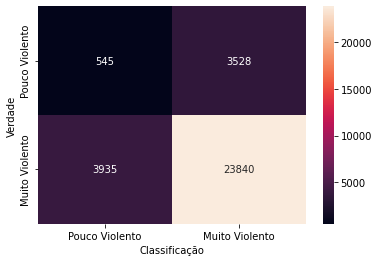

In [ ]:
cm = metrics.confusion_matrix(df_violencia_arv[df_violencia_arv['train_set'] == 0][target_col],
                              df_violencia_arv[df_violencia_arv['train_set'] == 0]['decision'])

sns.heatmap(cm, annot=True, fmt = '.0f')

plt.xlabel('Classificação')
plt.ylabel('Verdade')
plt.gca().set_xticklabels(label_map.TipoCluster.values)
plt.gca().set_yticklabels(label_map.TipoCluster.values)

### Métricas de Avaliação

A partir da avaliação da Matriz de Confusão foi preciso avaliar que o baixo número da precisão e do f1-score, portanto a assertividade da Árvore é questionada

In [ ]:
print(metrics.classification_report(df_violencia_arv[target_col],
                              df_violencia_arv['decision'],
                              target_names = label_map.TipoCluster.values))

                precision    recall  f1-score   support

Pouco Violento       0.62      0.49      0.55     20102
Muito Violento       0.90      0.94      0.92     99949

      accuracy                           0.87    120051
     macro avg       0.76      0.72      0.73    120051
  weighted avg       0.86      0.87      0.86    120051



### Distribuição de Probabilidade 

In [ ]:
label_map[label_map.clusters == 1].TipoCluster

0    Pouco Violento
Name: TipoCluster, dtype: object

In [ ]:
label_map

,clusters,TipoCluster
0,1,Pouco Violento
21,0,Muito Violento


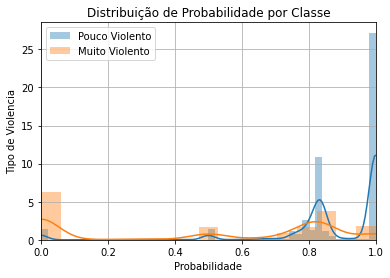

In [ ]:
plt.figure(figsize=(6,4))
for i in label_map.clusters.unique():
    sns.distplot(df_violencia_arv[df_violencia_arv[target_col] == i].probability,
                 label=label_map[label_map.clusters == i].TipoCluster,
                 ax = plt.gca())

plt.title('Distribuição de Probabilidade por Classe')
plt.ylabel('Tipo de Violencia')
plt.xlabel('Probabilidade')
plt.xlim((0,1))
plt.grid()
plt.legend()

### Curva ROC

Text(0, 0.5, 'Taxa de Detecção')

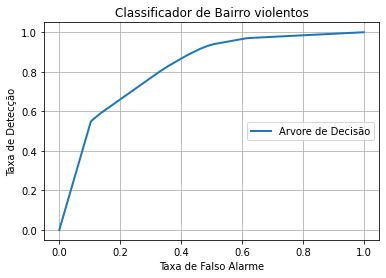

In [ ]:
plt.figure(figsize=(6,4))

fpr, tpr, thr = metrics.roc_curve(df_violencia_arv[target_col],
                                  df_violencia_arv['probability'])
plt.plot(fpr, tpr, '-', lw=2, label='Arvore de Decisão')

plt.legend(loc='right')
plt.title('Classificador de Bairro violentos')
plt.grid()
plt.xlabel('Taxa de Falso Alarme')
plt.ylabel('Taxa de Detecção')

### Regime de Operação

In [ ]:
label_map.clusters.values

array([1, 0])

In [ ]:
import warnings
warnings.filterwarnings('ignore')


def plot_operation_threshold(threshold):
    plt.figure(figsize=(12,4))
    # MATRIZ CONFUSAO
    plt.subplot(1,2,1)
    cm = metrics.confusion_matrix(df_violencia_arv[target_col],
                                  df_violencia_arv['probability'] > threshold)
    sns.heatmap(cm, annot=True, fmt = '.0f')
    plt.xlabel('Classificação')
    plt.ylabel('Verdade')
    plt.gca().set_xticklabels(label_map.TipoCluster.values)
    plt.gca().set_yticklabels(label_map.TipoCluster.values)
    # DISTRIBUICAO PROBABILIDADES
    plt.subplot(1,2,2)
    for i in label_map.clusters.values:
        sns.distplot(df_violencia_arv[df_violencia_arv[target_col] == i].probability,
                     label=label_map[label_map.clusters == i].TipoCluster,
                     ax = plt.gca())
    plt.plot([threshold, threshold], [0, plt.axis()[3]], '--k', lw=2, label = 'Corte Operação')
    plt.title('Distribuição de Probabilidade por Classe')
    plt.ylabel('Densidade Estimada')
    plt.xlabel('Probabilidade Violencia')
    plt.xlim((-0.01,1.01))
    plt.grid()
    plt.legend()
    plt.show()
    # PRINT CLASSIFICATION REPORT
    print(metrics.classification_report(df_violencia_arv[target_col],
                                        df_violencia_arv['probability'] > threshold,
                                        target_names = label_map.TipoCluster))    


interact(plot_operation_threshold, threshold=(0,1,0.1))

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0), Output()), _dom_classes=('widg…

<function __main__.plot_operation_threshold>

Obs -  Por se tratar de árvores com grande profundidade não foi feito a estrutura e o caminho da árvore

### Importancia das Variaveis

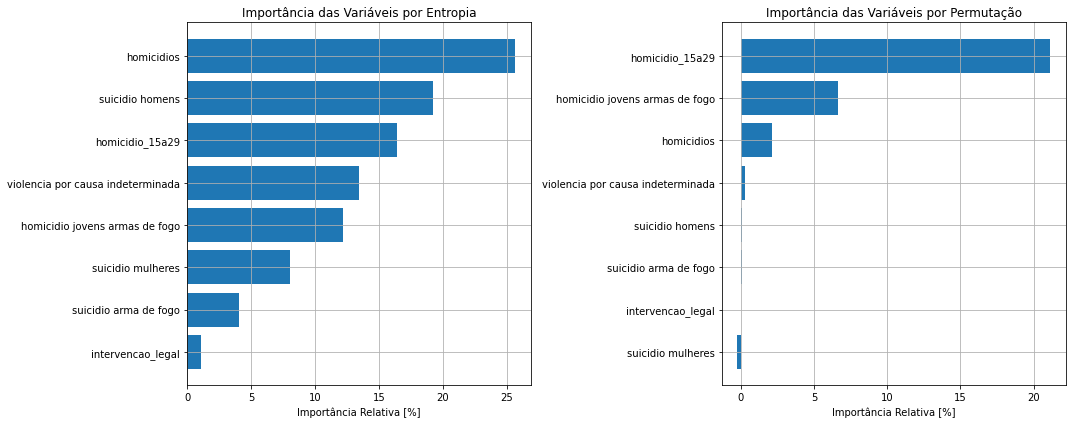

In [ ]:
plt.figure(figsize=(15,6))


plt.subplot(1,2,1)
idx = np.argsort(model_violencia.feature_importances_)

plt.barh(np.arange(idx.shape[0]), model_violencia.feature_importances_[idx]*100)

plt.yticks(np.arange(idx.shape[0]), np.array(violencia_feature_names)[idx])
plt.title('Importância das Variáveis por Entropia')
plt.grid()
plt.xlabel('Importância Relativa [%]')
plt.tight_layout()

plt.subplot(1,2,2)
r = permutation_importance(model_violencia, xtest, ytest,
                           n_repeats=30,
                        random_state=0)
importance =  r.importances_mean
idx = np.argsort(importance)
plt.barh(np.arange(idx.shape[0]), importance[idx]*100)
plt.yticks(np.arange(idx.shape[0]), np.array(violencia_feature_names)[idx])
plt.title('Importância das Variáveis por Permutação')
plt.grid()
plt.xlabel('Importância Relativa [%]')
plt.tight_layout()

## Resultado

 

*   O resultado da árvore absorve que deve se ter um número grande de profundidade da árvore para obter um melhor resultado 
*   Para a importancia dos dados obtidos foi verificado que o homicidio tem grande relevancia para avaliar se o municipio é violento ou não
*   Há um grande desequilibrio entre as duas classes a serem verificadas pois há mais municipios violentos que não violentos, então tende a precisão a ser desiquilibrada entre as duas classes e isso se repete também para o F1-Score
*   O alto acerto na acurácia se dá pelo desequilibrio das classes chegando a 90% de assertividade de acordo com o que foi solicitado





# REGRESSÃO LOGISTICA

Foi utilizada a regressão logistica pois para o problema em questão foi utilizada uma classificação

## Verificação dos Parametros

Mesmo com a variação dos modelos não houve variação do resultado

In [53]:
# train/test
xtrain = df_violencia[df_violencia['período'].isin(label_periodo)].drop(target_cols, axis=1)
xtest = df_violencia[df_violencia['período'].isin(label_periodo_tst)].drop(target_cols, axis=1)
ytrain = df_violencia[df_violencia['período'].isin(label_periodo)]['clusters']
ytest = df_violencia[df_violencia['período'].isin(label_periodo_tst)]['clusters']

In [54]:
df_train = df_violencia[df_violencia['período'].isin(label_periodo)]
df_test =  df_violencia[df_violencia['período'].isin(label_periodo_tst)]

In [55]:
grid_search_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none']
}


def plot_parameter_validation_curve(param_name, grid_search,
                                    model, model_name, scoring,
                                    logx):
    print('Parameter:', param_name)
    print('GridSearch:', grid_search[param_name])
    print('Scoring:', scoring)
    plt.figure(figsize=(6,4))
    train_scores, test_scores = validation_curve(model,
                                                 X = xtrain, 
                                                 y = ytrain, 
                                                 param_name=param_name, 
                                                 param_range= grid_search[param_name],
                                                 scoring=scoring,
                                                 cv=cvfold,
                                                 n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Curva Validação Modelo " + model_name)
    plt.xlabel(param_name)
    plt.ylabel("Score ("+scoring+")")
    if logx:
        plt.semilogx(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.semilogx(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                     color="navy", lw=2)
    else:
        plt.plot(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.plot(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                 color="navy", lw=2)
    plt.fill_between(grid_search[param_name], train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=2)
    plt.fill_between(grid_search[param_name], test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=2)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
interact(plot_parameter_validation_curve,
         param_name = list(grid_search_lr.keys()), 
         grid_search = fixed(grid_search_lr),
         model = fixed(lm.LogisticRegression(solver='liblinear')),
         model_name = fixed('Regressão Logística'),
         scoring = classification_scores,
         logx = True
)

interactive(children=(Dropdown(description='param_name', options=('C', 'penalty'), value='C'), Dropdown(descri…

<function __main__.plot_parameter_validation_curve>

## Modelo dos Dados

In [57]:
df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[target_col] = ytrain
df_test[target_col] = ytest


model_violencia = lm.LogisticRegression(penalty='l1', solver='liblinear')
model_violencia.fit(xtrain, ytrain)
df_train['decision'] = model_violencia.predict(xtrain)
df_test['decision']  = model_violencia.predict(xtest)
df_train['probability'] = model_violencia.predict_proba(xtrain)[:,1]
df_test['probability']  = model_violencia.predict_proba(xtest)[:,1]

df_violencia_log = pd.concat((df_train, df_test), axis=0)

In [58]:
df_violencia_log[df_violencia_log['train_set'] == 0]['clusters'].value_counts()

1    27775
0     4073
Name: clusters, dtype: int64

In [59]:
df_violencia_log[df_violencia_log['train_set'] == 0]['decision'].value_counts()

1    31848
Name: decision, dtype: int64

## Métricas de Avaliação

### Matriz de Confusão

[Text(0, 0.5, 'Pouco Violento'), Text(0, 1.5, 'Muito Violento')]

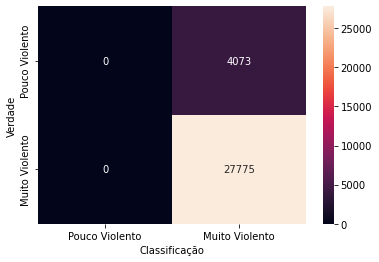

In [ ]:
cm = metrics.confusion_matrix(df_violencia_log[df_violencia_log['train_set'] == 0][target_col],
                              df_violencia_log[df_violencia_log['train_set'] == 0]['decision'])

sns.heatmap(cm, annot=True, fmt = '.0f')

plt.xlabel('Classificação')
plt.ylabel('Verdade')
plt.gca().set_xticklabels(label_map.TipoCluster.values)
plt.gca().set_yticklabels(label_map.TipoCluster.values)

### Curva ROC

Text(0, 0.5, 'Taxa de Detecção')

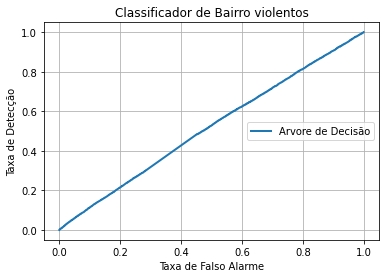

In [ ]:
plt.figure(figsize=(6,4))

fpr, tpr, thr = metrics.roc_curve(df_violencia_log[target_col],
                                  df_violencia_log['probability'])
plt.plot(fpr, tpr, '-', lw=2, label='Arvore de Decisão')

plt.legend(loc='right')
plt.title('Classificador de Bairro violentos')
plt.grid()
plt.xlabel('Taxa de Falso Alarme')
plt.ylabel('Taxa de Detecção')

### Distribuição de Probabilidade

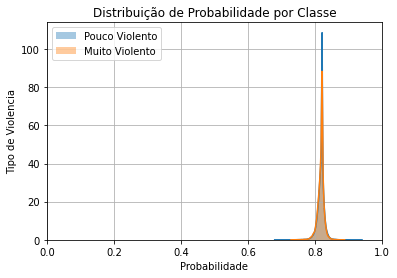

In [ ]:
plt.figure(figsize=(6,4))
for i in label_map.clusters.unique():
    sns.distplot(df_violencia_log[df_violencia_log[target_col] == i].probability,
                 label=label_map[label_map.clusters == i].TipoCluster,
                 ax = plt.gca())

plt.title('Distribuição de Probabilidade por Classe')
plt.ylabel('Tipo de Violencia')
plt.xlabel('Probabilidade')
plt.xlim((0,1))
plt.grid()
plt.legend()

### Métricas de Avaliação

Pela precisão ter o mesmo valor da acurácia pois não há classificação do municipio pouco violento

In [ ]:
print(metrics.classification_report(df_violencia_log[target_col],
                              df_violencia_log['decision'],
                              target_names = label_map.TipoCluster.values))

                precision    recall  f1-score   support

Pouco Violento       0.00      0.00      0.00     20102
Muito Violento       0.83      1.00      0.91     99949

      accuracy                           0.83    120051
     macro avg       0.42      0.50      0.45    120051
  weighted avg       0.69      0.83      0.76    120051



###Estimativa dos Parâmetros 

In [ ]:
from statsmodels.discrete import discrete_model

logit = discrete_model.Logit(ytrain, xtrain).fit()

logit.summary()

Optimization terminated successfully.
         Current function value: 0.554948
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               clusters   No. Observations:                88203
Model:                          Logit   Df Residuals:                    88195
Method:                           MLE   Df Model:                            7
Date:                Fri, 24 Jun 2022   Pseudo R-squ.:                 -0.1708
Time:                        05:18:22   Log-Likelihood:                -48948.
converged:                       True   LL-Null:                       -41809.
Covariance Type:            nonrobust   LLR p-value:                     1.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
homicidios                            0.0313      0.001     43.930      0.000       0.030       0.033
homicidio jovens armas de fogo       -0.0039      0.001     -7.318      0.000      -0.005      -0.003
suicidio arma de fogo                -0.0014      0.003     -0.434      0.664      -0.008       0.005
violencia por causa indeterminada     0.0433      0.001     37.067      0.000       0.041       0.046
suicidio homens                       0.0242      0.001     44.471      0.000       0.023       0.025
suicidio mulheres                     0.0211      0.001     19.954      0.000       0.019       0.023
intervencao_legal                     0.0242      0.012      1.982      0.047       0.000       0.048
homicidio_15a29                       0.0014      0.000      2.874      0.004       0.000       0.002
=====================================================================================================
"""

## Resultado

*   Há poucas distinções entre os diferentes modelos pois a classe alvo não conseguiu diferenciar os valores
*   Não diferencia os valores de acordo com a mudança no modelo
*   Pela diferenciação dos tamanhos da classe, temos somente a escolha na maior classe e a acurácia chega em 87%





#SVM

## Preparação da Base

Obs - Para uma melhor utilização dos modelos os dados foram transformados para obter uma melhor eficiencia na geração do modelo utilizado

In [62]:
xtrain = df_violencia[df_violencia['período'].isin(label_periodo)].drop(target_cols, axis=1)
xtest = df_violencia[df_violencia['período'].isin(label_periodo_tst)].drop(target_cols, axis=1)
ytrain = df_violencia[df_violencia['período'].isin(label_periodo)]['clusters']
ytest = df_violencia[df_violencia['período'].isin(label_periodo_tst)]['clusters']

In [63]:
df_train = df_violencia[df_violencia['período'].isin(label_periodo)]
df_test =  df_violencia[df_violencia['período'].isin(label_periodo_tst)]

In [23]:
xtest.drop(['cod','período'],axis=1)

,homicidios,homicidio jovens armas de fogo,suicidio arma de fogo,violencia por causa indeterminada,suicidio homens,suicidio mulheres,intervencao_legal,homicidio_15a29
109475,0.00,0.0,32.2,0.00,2.0,0.0,0.0,0.00
109476,0.00,0.0,32.2,0.00,2.0,0.0,0.0,0.00
109477,106.95,0.0,0.0,0.00,0.0,0.0,0.0,0.00
109478,106.95,0.0,0.0,0.00,0.0,0.0,0.0,0.00
109479,5.94,0.0,0.0,0.00,2.0,0.0,0.0,25.91
...,...,...,...,...,...,...,...,...
120046,44.03,0.0,8.8,0.00,2.0,19.6,0.0,41.89
120047,18.44,0.0,0.0,9.21,0.0,0.0,0.0,0.00
120048,18.44,0.0,0.0,9.21,0.0,0.0,0.0,0.00
120049,19.74,0.0,0.0,0.00,1.0,0.0,0.0,37.66


In [24]:
conversor = MinMaxScaler(feature_range=(-1,1))
#conversor = StandardScaler()
xtrain = conversor.fit_transform(xtrain)
xtest = conversor.transform(xtest)

## Verificação dos Parametros

Obs - Pela lentidão gerada para gerar os dados pelo modelo SVM foi utilizada o cálculo e escolha dos parametros através da melhor escolha de acurácia pelos parametros selecionados 

In [ ]:
def verificacao_parametros(kernel,custo):
  model_violencia = svm.SVC(kernel=kernel, C=custo, probability=True)
  model_violencia = model_violencia.fit(xtrain, ytrain)
  ypred = model_violencia.predict(xtest)
  return accuracy_score(ytest, ypred)

### Min Max Scaler

In [ ]:
verificacao_parametros('linear',0.1)

0.8026664145234493

In [ ]:
verificacao_parametros('linear',1)

0.8026664145234493

In [ ]:
verificacao_parametros('rbf',0.1)

0.8026664145234493

In [ ]:
verificacao_parametros('poly',0.1)

0.8026664145234493

### StandardScaler

In [65]:
conversor = StandardScaler()
xtrain = conversor.fit_transform(xtrain)
xtest = conversor.transform(xtest)

In [ ]:
verificacao_parametros('linear',0.1)

0.8026664145234493

In [ ]:
verificacao_parametros('rbf',0.1)

0.8026664145234493

## Modelo dos Dados

In [66]:
violencia_target_col = ['período', 'homicidios', 'homicidio jovens armas de fogo',
       'suicidio arma de fogo', 'violencia por causa indeterminada',
       'suicidio homens', 'suicidio mulheres', 'intervencao_legal',
       'homicidio_15a29']

In [68]:
target_col = 'clusters'

In [69]:
# C = [0.1, 1, 10, 1000],
# kernel = ['linear', 'rbf', 'poly']

model_violencia = svm.SVC(kernel='linear', C=0.1, probability=True)
model_violencia = model_violencia.fit(xtrain, ytrain)

df_train['train_set'] = 1
df_test['train_set'] = 0
df_test['decision'] = model_violencia.predict(xtest)
df_train['decision'] = model_violencia.predict(xtrain)
df_train['probability'] = model_violencia.predict_proba(xtrain)[:,1]
df_test['probability']  = model_violencia.predict_proba(xtest)[:,1]
df_violencia_svm = pd.concat((df_train, df_test), axis=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [70]:
df_violencia_svm[df_violencia_svm['train_set'] == 0]['clusters'].value_counts()

1    27775
0     4073
Name: clusters, dtype: int64

In [71]:
df_violencia_svm[df_violencia_svm['train_set'] == 0]['decision'].value_counts()

1    31848
Name: decision, dtype: int64

## Métricas de Avaliação

###Matriz de Confusão

[Text(0, 0.5, 'Pouco Violento'), Text(0, 1.5, 'Muito Violento')]

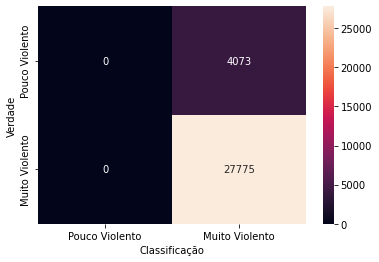

In [72]:
cm = metrics.confusion_matrix(df_violencia_svm[df_violencia_svm['train_set'] == 0][target_col],
                              df_violencia_svm[df_violencia_svm['train_set'] == 0]['decision'])

sns.heatmap(cm, annot=True, fmt = '.0f')

plt.xlabel('Classificação')
plt.ylabel('Verdade')
plt.gca().set_xticklabels(label_map.TipoCluster.values)
plt.gca().set_yticklabels(label_map.TipoCluster.values)

### Curva ROC

Text(0, 0.5, 'Taxa de Detecção')

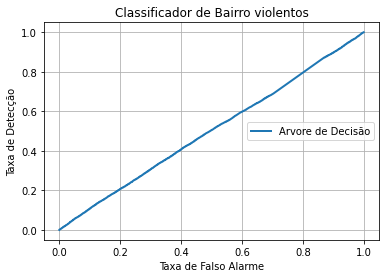

In [73]:
plt.figure(figsize=(6,4))

fpr, tpr, thr = metrics.roc_curve(df_violencia_svm[target_col],
                                  df_violencia_svm['probability'])
plt.plot(fpr, tpr, '-', lw=2, label='Arvore de Decisão')

plt.legend(loc='right')
plt.title('Classificador de Bairro violentos')
plt.grid()
plt.xlabel('Taxa de Falso Alarme')
plt.ylabel('Taxa de Detecção')

### Distribuição de Probabilidade

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


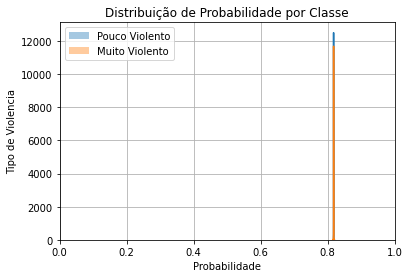

In [75]:
plt.figure(figsize=(6,4))
for i in label_map.clusters.unique():
    sns.distplot(df_violencia_svm[df_violencia_svm[target_col] == i].probability,
                 label=label_map[label_map.clusters == i].TipoCluster,
                 ax = plt.gca())

plt.title('Distribuição de Probabilidade por Classe')
plt.ylabel('Tipo de Violencia')
plt.xlabel('Probabilidade')
plt.xlim((0,1))
plt.grid()
plt.legend()

### Métricas de Avaliação

Pela precisão ter o mesmo valor da acurácia pois não há classificação do municipio pouco violento

In [76]:
print(metrics.classification_report(df_violencia_svm[target_col],
                              df_violencia_svm['decision'],
                              target_names = label_map.TipoCluster.values))

                precision    recall  f1-score   support

Pouco Violento       0.00      0.00      0.00     20102
Muito Violento       0.83      1.00      0.91     99949

      accuracy                           0.83    120051
     macro avg       0.42      0.50      0.45    120051
  weighted avg       0.69      0.83      0.76    120051



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [82]:
import warnings
warnings.filterwarnings('ignore')


def plot_operation_threshold(threshold):
    plt.figure(figsize=(12,4))
    # MATRIZ CONFUSAO
    plt.subplot(1,2,1)
    cm = metrics.confusion_matrix(df_violencia_svm[target_col],
                                  df_violencia_svm['probability'] > threshold)
    sns.heatmap(cm, annot=True, fmt = '.0f')
    plt.xlabel('Classificação')
    plt.ylabel('Verdade')
    plt.gca().set_xticklabels(label_map.TipoCluster.values)
    plt.gca().set_yticklabels(label_map.TipoCluster.values)
    # DISTRIBUICAO PROBABILIDADES
    plt.subplot(1,2,2)
    for i in label_map.clusters.unique():
        sns.distplot(df_violencia_svm[df_violencia_svm[target_col] == i].probability,
                     label=label_map[label_map.clusters == i].TipoCluster,
                     ax = plt.gca())
    plt.plot([threshold, threshold], [0, plt.axis()[3]], '--k', lw=2, label = 'Corte Operação')
    plt.title('Distribuição de Probabilidade por Classe')
    plt.ylabel('Densidade Estimada')
    plt.xlabel('Probabilidade Alta Qualidade')
    plt.xlim((-0.01,1.01))
    plt.grid()
    plt.legend()
    plt.show()
    # PRINT CLASSIFICATION REPORT
    print(metrics.classification_report(df_violencia_svm[target_col],
                                        df_violencia_svm['probability'] > threshold,
                                        target_names = label_map.TipoCluster.values))


In [85]:
    interact(plot_operation_threshold, threshold=(0,1,0.02))

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

<function __main__.plot_operation_threshold>

## Resultado

*   Não houve uma variação da acurácia mesmo com a modificação dos modelos
*   Para tornar funcional o SVM foi necessário converter os dados para o MinMax e StandardScaler
*   Pela diferneça entre os valores alvos não gerou os valores necessário





# Resultado Final

Os resultados foram pouco conclusivos por que temos que os dados de maneira 
pouca balanceada fazendo com que tenhamos um valor baixo na assertividade do modelo. 

Deve ser avaliado para utilizar mais classificações e tornar a base original mais balanceada para ter um resultado mais assertivo e utilizar a base na seguradora desejada.

O projeto pode ser expandido para utilizar outras classes sem ser do Atlas da violencia, como dados sociodemográficos e caracteristicas geográficas como região e talvez comparar com outros países semelhantes ao Brasil